In [1]:
!pip install rdkit
!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 13.4 MB/s eta 0:00:00
Looking in links: https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.3/797.3 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/1

In [2]:
!git clone https://github.com/adithyamauryakr/CIGIN-DevaLab.git

Cloning into 'CIGIN-DevaLab'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 151 (delta 30), reused 20 (delta 20), pack-reused 105 (from 1)
Receiving objects: 100% (151/151), 4.39 MiB | 13.64 MiB/s, done.
Resolving deltas: 100% (77/77), done.


In [3]:
import random
import pandas as pd
import pickle
import os
import sys
import warnings
from collections import OrderedDict
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from rdkit import Chem, DataStructs
from rdkit.Chem import rdMolDescriptors as rdDesc
from rdkit.Chem import AllChem
from rdkit import rdBase
from rdkit import RDLogger


import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data


In [4]:
%cd CIGIN-DevaLab/

/content/CIGIN-DevaLab


In [7]:
sys.path.insert(0, './CIGIN_V2/')
from molecular_graph import *
from model import CIGINModel

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Loading the model

In [10]:
model=CIGINModel().to(device)
model.load_state_dict(torch.load('best_model.tar'))
model.eval()

<ipython-input-10-02b12474a391>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.tar'))


CIGINModel(
  (solute_gather): GatherModel(
    (lin0): Linear(in_features=42, out_features=42, bias=True)
    (set2set): Set2Set(
      n_iters=2
      (lstm): LSTM(84, 42)
    )
    (message_layer): Linear(in_features=84, out_features=42, bias=True)
    (conv): NNConv(
      (edge_func): Sequential(
        (0): Linear(in_features=10, out_features=10, bias=True)
        (1): ReLU()
        (2): Linear(in_features=10, out_features=1764, bias=True)
      )
      (res_fc): Identity()
    )
  )
  (solvent_gather): GatherModel(
    (lin0): Linear(in_features=42, out_features=42, bias=True)
    (set2set): Set2Set(
      n_iters=2
      (lstm): LSTM(84, 42)
    )
    (message_layer): Linear(in_features=84, out_features=42, bias=True)
    (conv): NNConv(
      (edge_func): Sequential(
        (0): Linear(in_features=10, out_features=10, bias=True)
        (1): ReLU()
        (2): Linear(in_features=10, out_features=1764, bias=True)
      )
      (res_fc): Identity()
    )
  )
  (fc1): Linear

### Predicting free energy of solvation

In [17]:
import dgl
from utils import *

In [12]:
solute = 'OCCN'
mol = Chem.MolFromSmiles(solute)
mol = Chem.AddHs(mol)
solute = Chem.MolToSmiles(mol)
solute_graphs = get_graph_from_smile(solute)
# print('solvent',self.dataset.iloc[idx]['SolventSMILES'])
solvent = 'OCC'

mol = Chem.MolFromSmiles(solvent)
mol = Chem.AddHs(mol)
solvent = Chem.MolToSmiles(mol)

solvent_graphs = get_graph_from_smile(solvent)
delta_g = -9.5

/usr/local/lib/python3.11/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(
[14:20:01] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:20:01] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:20:01] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:20:01] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:20:01] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:20:01] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:20:01] DEPRECATION WARNING: please use GetValence(getExplicit=False)


In [35]:
from rdkit import Chem
import torch
import dgl
import numpy as np

# Assume you have this helper
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    smiles = Chem.MolToSmiles(mol)
    return get_graph_from_smile(smiles)

# Your SMILES strings
solute_smiles = "OCCN"         # ethanol
solvent_smiles = "OCC"          # water

# 1. Convert to DGL graphs
solute_graph = smiles_to_graph(solute_smiles)
solvent_graph = smiles_to_graph(solvent_smiles)

# 2. Batch (even for a single pair, required for DGL interface)
solute_batched = dgl.batch([solute_graph])
solvent_batched = dgl.batch([solvent_graph])

# 3. Get node count masks
solute_len_matrix = get_len_matrix(solute_batched.batch_num_nodes().tolist())
solvent_len_matrix = get_len_matrix(solvent_batched.batch_num_nodes().tolist())

# 4. Convert len_matrix to tensors
solute_len_matrix = torch.tensor(solute_len_matrix).float()
solvent_len_matrix = torch.tensor(solvent_len_matrix).float()

# 5. Move to GPU if necessary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
solute_batched = solute_batched.to(device)
solvent_batched = solvent_batched.to(device)
solute_len_matrix = solute_len_matrix.to(device)
solvent_len_matrix = solvent_len_matrix.to(device)

# 6. Model inference
model.eval()
with torch.no_grad():
    prediction, interaction_map = model([solute_batched, solvent_batched,
                                         solute_len_matrix, solvent_len_matrix])
    print("Predicted ΔG_solv:", prediction.item())


Predicted ΔG_solv: -7.182659149169922


/usr/local/lib/python3.11/dist-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(
[14:44:24] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:44:24] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:44:24] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:44:24] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:44:24] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:44:24] DEPRECATION WARNING: please use GetValence(getExplicit=False)
[14:44:24] DEPRECATION WARNING: please use GetValence(getExplicit=False)


### Analysis of interaction map

In [24]:
# Applying min max normalization across the interaction map

min_value = min(interaction_map.flatten())
max_value = max(interaction_map.flatten())
interaction_map = ((interaction_map-min_value)/(max_value-min_value))

### Solute

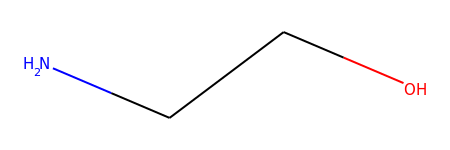

In [ ]:
Chem.MolFromSmiles(solute) #OCCN

### Solvent

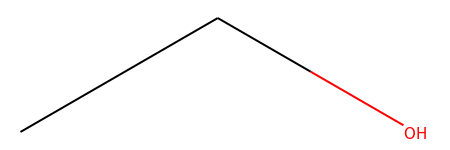

In [ ]:
Chem.MolFromSmiles(solvent) #OCC

### Interaction map

In [39]:
interaction_map

array([[9.42548  , 4.5479813, 5.349869 ],
       [4.121788 , 7.175681 , 5.0522413],
       [4.2019415, 7.450647 , 5.2128477],
       [7.3416576, 5.241465 , 5.274045 ]], dtype=float32)

In [37]:
interaction_map = interaction_map.to('cpu').numpy()

Text(0.5, 23.52222222222222, 'Solvent')

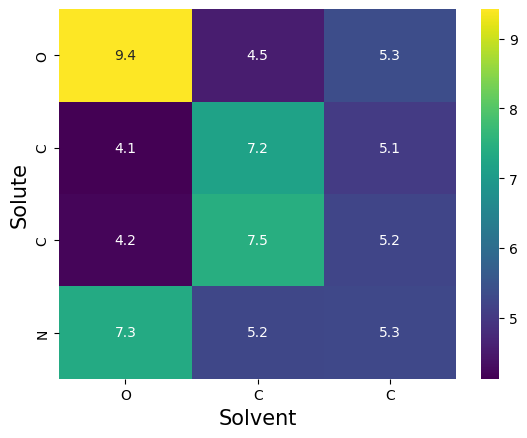

In [38]:
sns.heatmap(interaction_map,annot=True,xticklabels=['O','C','C'],yticklabels=['O','C','C','N'],cmap='viridis')
plt.ylabel('Solute',size='15')
plt.xlabel('Solvent',size='15')

Text(0.5, 15.0, 'Solvent')

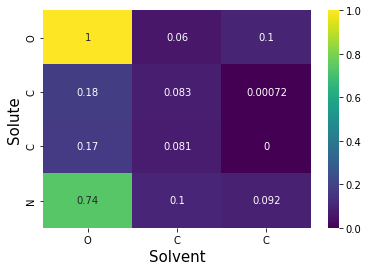

In [ ]:
sns.heatmap(interaction_map,annot=True,xticklabels=['O','C','C'],yticklabels=['O','C','C','N'],cmap='viridis')
plt.ylabel('Solute',size='15')
plt.xlabel('Solvent',size='15')